In [2]:
import cv2
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
# Will be using InceptionResNetV2 model as base model for transfer learning
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import dlib
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import seaborn as sn
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from statistics import mode
import os

### Steps To follow for Transfer Learning

* Convert Videos to Frames

* Extract faces from frames

* Store cropped faces in two different folder - original and deepfake

* Retrain the final layer of InceptionResNetV2 CNN

* Test the model on a video (Video -> Frames -> faces -> Input to Model)


### Directory Structure Used

--**Deepfake_dataset** // Holds all the fake videos <br />
  | <br />
  **Deepfake_dataset_original** // Holds all the original videos<br />
  |<br />
  **Inception_data** // Holds all the folders for face extraction and frame processing<br />
  |-----|<br />
  |----**Frames** // Holds all the folders for extracted faces<br />
  |--------|<br />
  |--------**deepfake** // Holds all the deepfake faces for training set<br />
  |--------|<br />
  |--------**original** // Holds all the original faces for test set<br />
  |--------|<br />
  |--------**deepfake_test** // Holds all the deepfake faces for test set<br />
  |--------|<br />
  |--------**original_test** //Holds all the original faces for test set<br />
  |--------|<br />
  |--------**vid_frames** // folder created and used to store extracted faces when model is used for video classification<br />
  |<br />
  |<br />
  |<br />
  **0_video_df.csv** //csv generated for path and video name of all original videos<br />
  |<br />
  **1_video_df.csv** //csv generated for path and video name of half deepfake videos<br />
  |<br />
  **1_video_df_2.csv** //csv generated for path and video name of other half deepfake videos

### ***IMPORTANT TO READ***

All the code blocks below are numbered and resource and memeory intensive. Hence please read the instructions below before executing any of the blocks:

+ Make sure you have set up the above directory structure and have the required csv files.

You can execute a series of blocks to perform a particular phase once and then can skip the blocks while performing other phases:

+ Data pre processing phase : Execution sequence (1 - 2 - 3 - 4 - 5) MUST RUN ONCE 
+ Training phase : Execution sequence (6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14) MUST RUN ONCE
+ Model Prediction : Execution Sequence ( 3 - 6 - 7 - 15 - 16 - 17 -18)

### Food for Thought

Transfer learning with CNN only takes into account the spatial features of a video. Video is a sequence of frames. For some videos the sequence might matter and for some the frames might be independent. For example, if you want to tell if a video is a football match or an advertisement, sequence of frames might sound important enough. However, if you want to tell a video is original or deepfake, do you think sequence of frames matter?

If sequence does matter then we should prefere a neural network that can remember previous frames, so an artificial recurrent neural net LSTM (Long Short Term Memory) can be more useful. If sequence doesn't matter and frames are independent, then a CNN might be all we need.

## Setup the Data Pipeline

### 1. Method to extract face using dlib

In [3]:
def dlib_face_extract(vid_no,frame,frames,label,out_loc,detector):
    rects,scores,idx = detector.run(frame,1)
    for i,d in enumerate(rects):
        x1 = d.left()
        y1 = d.top()
        x2 = d.right()
        y2 = d.bottom()
        crop_img = frame[(y1-80):(y2), (x1):(x2)]
        if (crop_img.shape[1]>110 and crop_img.shape[0]>0 and crop_img.shape[2]>0): #To control noise in face extraction
            cv2.imwrite(out_loc+label+str(vid_no)+'_'+str(frames)+'_'+str(i)+'.jpg',crop_img)

### 2. Method to convert video into frames

In [28]:
def conv_vid_frames(label,df,out_loc):
    # get all .mp4 files in the location and iterate to create frames
    num_videos = 0
    detector = dlib.get_frontal_face_detector()
    for f in df:
        vid = cv2.VideoCapture(f)
        frames = 0
        while(vid.isOpened()):
            # Will generate 1 frame per second i.e 60 frames/min
            vid.set(cv2.CAP_PROP_POS_MSEC,(frames*1000))
            flag,frame = vid.read()
            if flag==True:
                #Extract faces from frames and store in output location
                dlib_face_extract(num_videos,frame,frames,label,out_loc,detector)
                frames = frames + 1
            else:
                break
        vid.release()
        cv2.destroyAllWindows()
        num_videos = num_videos + 1
    print(str(dt.datetime.now()))
    print('Frame conversion Successfull')

### 3. Prepare Dataset in Training and Testing Data

** NOTE ** Following 3 csv files will be required from part 1 of analysis:
+ 0_video_df.csv : File having paths of original videos
+ 1_video_df.csv : File having paths of 50% deepfake videos
+ 1_video_df_2.csv : File having paths of other 50% deepfake videos


In [4]:
## MODIFY PATH NAMES HERE ##
# Location of Original videos to be changed here
orig_loc= 'D:\\\\MDA Stuff\\\\Artificial Intelligence 2\\\\DeepFake_Detection_Project\\\\deepfake_dataset_original\\\\original_sequences\\\\actors\\\\c23\\\\videos\\\\'

# Read the csv file for original videos created for Part 1
orig_video = pd.read_csv('D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\0_video_df.csv')

# Manipulate the path location of original videos. (CAUTION : REGEX ZONE)
orig_video['path'] = orig_video['path'].replace(regex='.*videos\\\\',value='')
orig_video['path'] = orig_video['path'].replace(regex='^',value=orig_loc)

# Location of Deep Fake videos to be changed here
fake_loc= 'D:\\\\MDA Stuff\\\\Artificial Intelligence 2\\\\DeepFake_Detection_Project\\\\deepfake_dataset\\\\manipulated_sequences\\\\DeepFakeDetection\\\\c23\\\\videos\\\\'

# Read the csv file for fake videos created for Part 1
df_video = pd.read_csv("D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\1_video_df.csv")
df_video2 = pd.read_csv("D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\1_video_df_2.csv")

# Manipulate the path location of deepfake videos (CAUTION : REGEX ZONE)
df_video['path'] = df_video['path'].replace(regex='.*videos_first_half\\\\',value='')
df_video['path'] = df_video['path'].replace(regex='^',value=fake_loc)

df_video2['path'] = df_video2['path'].replace(regex='.*videos\\\\',value='')
df_video2['path'] = df_video2['path'].replace(regex='^',value=fake_loc)

df_video = pd.concat([df_video, df_video2])
# Filter out only deepfake video with one person
df_video = df_video[df_video['path'].str.contains('__walking_outside_cafe_disgusted__|__talking_against_wall__|__outside_talking_pan_laughing__|__kitchen_still__|__exit_phone_room__|__walking_down_street_outside_angry__|__secret_conversation__|__podium_speech_happy__|__outside_talking_still_laughing__|__kitchen_pan__|__walk_down_hall_angry__',regex=True)]

# Select 363 videos at random from the filtered deepfake videos of one person
df_video=df_video.sample(n=363, random_state=1).reset_index(drop=True)
data = pd.concat([orig_video, df_video])
data = data.path

# Split data into train test dataset
train, test = train_test_split(data, test_size = 0.15, random_state = 0)       

### 4. Extract Faces from Training Dataset

In [3]:
## MODIFY PATH NAMES HERE ##
orig_op_loc = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\original\\'
orig_label = 'original'

fake_op_loc = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\deepfake\\'
fake_label = 'fake'

org_train_df = train[train.str.contains('original_sequences')]
fake_train_df = train[train.str.contains('manipulated_sequences')]

print(str(dt.datetime.now()))
conv_vid_frames(orig_label,org_train_df,orig_op_loc)
conv_vid_frames(fake_label,fake_train_df,fake_op_loc)

2020-04-27 13:51:02.154340


### 5. Extract Faces from Test Dataset

In [4]:
## MODIFY PATH NAMES HERE ##
orig_op_loc_test = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\original_test\\'
orig_label = 'original'

fake_op_loc_test = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\deepfake_test\\'
fake_label = 'fake'

org_test_df = test[test.str.contains('original_sequences')]
fake_test_df = test[test.str.contains('manipulated_sequences')]

print(str(dt.datetime.now()))
conv_vid_frames(orig_label,org_test_df,orig_op_loc_test)
conv_vid_frames(fake_label,fake_test_df,fake_op_loc_test)

2020-04-27 13:51:05.578890


**NOTE** : All the output directories should already exist

### 6. Convert Training Data into Image Array

In [9]:
# Each data point (X,Y)
# X : image array, Y: Label (0 is Fake, 1 is Original)
##### MODIFY PATH NAMES HERE #############
orig_op_loc_test = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\original_test\\'
fake_op_loc_test = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\deepfake_test\\'
fake_op_loc = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\deepfake\\'
orig_op_loc = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\original\\'

# Read original frames
orig_frames = [file for file in glob.glob(orig_op_loc + '*.jpg',recursive=True)]

X =[]
y =[]

for f in orig_frames:
    img = load_img(f,target_size=(128,128)) # 
    img = img_to_array(img).flatten()
    X.append(img)
    y.append(1)

# Read fake frames
fake_frames = [file for file in glob.glob(fake_op_loc + '*.jpg',recursive=True)]

for f in fake_frames:
    img = load_img(f,target_size=(128,128))
    img = img_to_array(img).flatten()
    X.append(img) 
    y.append(0)

X_train = np.array(X)
y_train = to_categorical(y,2)
X_train = X_train.reshape(-1, 128, 128, 3)

In [10]:
X_train.shape

(19349, 128, 128, 3)

### 7. Convert Testing Data into Image Array

In [5]:
# Each data point (X,Y)
# X : image array, Y: Label (0 is Fake, 1 is Original)

# Read original frames
orig_tst_frames = [file for file in glob.glob(orig_op_loc_test + '*.jpg',recursive=True)]

X =[]
y =[]

for f in orig_tst_frames:
    img = load_img(f,target_size=(128,128)) # 
    img = img_to_array(img).flatten()
    X.append(img)
    y.append(1)

# Read fake frames
fake_tst_frames = [file for file in glob.glob(fake_op_loc_test + '*.jpg',recursive=True)]

for f in fake_tst_frames:
    img = load_img(f,target_size=(128,128))
    img = img_to_array(img).flatten()
    X.append(img) 
    y.append(0)

X_val = np.array(X)
y_true = y
y_val = to_categorical(y,2)
X_val = X_val.reshape(-1, 128, 128, 3)

## Model Designing

### 8. Import and setup base model

We will use the InceptionResNetV2 pretrained model for transfer learning. We will reconfigure the model and use all its layer except the the last fully connected layer (include_top= False). InceptionResNetV2 is trained on imagenet dataset, so we will use the pretrained weights from imagenet (weights = 'imagenet'). Our frames are scaled to size of (128,128) and since they have 3 RGB channel, the input to the model will be of shape (128,128,3).

In [13]:
Inception_mod_trained = InceptionResNetV2(input_shape = (128,128,3),
                                               include_top = False,
                                               weights = 'imagenet')

We will freeze all the layers so that they are not trained further. We can further de-freeze some layer to retrain depending upon the model performance. Since this is a pretrained model, trained on powerful GPUs for hours, any extra re-training of layers during transfer learning process might result in overfitting.

In [14]:
for layer in Inception_mod_trained.layers:
    layer.trainable = False

In [15]:
## Defreeze all batch normalization layers due to a bug in transfer learning using keras
for layer in Inception_mod_trained.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [16]:
## Check the model architecture of pre-trained InceptionResNetV2 model
Inception_mod_trained.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

### 9. Class to control the model accuracy and training epochs

This class will comprise of a method will assist in controlling the training epochs if the desired accuracy is reached. For example if we want to reach an accuracy of 95% and it is reached in 10 epochs out of the determined 100 epochs, the training will be stopped at 10 epochs. This method is useful as this is a computationally intensive process.

In [17]:
class TrainingAcc(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}) :
        if(logs.get('acc')>0.80): # accuracy can be tuned here for controlling the training epochs
            print("\n Model accuracy reached 80%, halting training in 3 2 1..")
            self.model.stop_training = True
            print("\n Training stopped successfully")

### 10. Configure model parameters for the Additive model

We are using the transfer learning, which means that we will be using a pre-trained base model along with our own model architecture such that the learning from pre-trained model can be transferred to this additive model which can then use the learning to get the best possible output.

Final Model = InceptionResNetV2 Pre-trained + Additive Model

We will be using following model parameters for additive model:

Since we have a binary classification use case (original or deepfake) we will be using binary cross entropy as loss metric
+ loss = 'binary_crossentropy'

Optimizers are important as they make computer learn. Every neural net has a loss function which tells how wrong the the network is performing with training and validation data. This is where we use algorithm like backpropagation that decides on which direction the weights should be adjusted to minimise the loss by adjusting the learning rate of model. If learning rate is too high, model can step over the minimum loss value or if learning rate is too low the model will never reach the minimum loss value. So we use optimizers that can automatically determise the learning rate and help the model learn faster without getting stuck or over stepping.

We are using Adam optimizer which can be experimented alternatively with Adagrad and RMSprop optimizers
+ optimizer = Adam()

We will start with a learning rate of 0.00001
+ optimizer = Adam(lr=0.00001)

We will be using one global average pooling layer, one dense fully connected layer with 1024 hidden neurons with ReLu activation and another dense layer with softmax activation for classification.

We will be using dropout layer to avoid overfitting. Simply said, dropout layers are used to ignore hidden neurons from from the forward or backward pass. We ignore them to make up for the fact that the neurons in the layer might have learned too much.

In [18]:
final_model = Sequential()
# Add the base model for transfer learning
final_model.add(Inception_mod_trained)

# Add custom layer architecture
final_model.add(layers.GlobalAveragePooling2D())
final_model.add(layers.Dense(1024,activation='relu'))
final_model.add(layers.Dropout(0.5))
final_model.add(layers.Dense(2,activation='softmax'))

final_model.compile(optimizer = Adam(lr=1e-5), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [19]:
# Check the structure of combined model. 
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 55,912,674
Trainable params: 1,606,210
Non-trainable params: 54,306,464
_________________________________________________________________


## Setup Input Pipeline for Designed Model

### 11. Design the Data generators and Image generators

The idea behind using Image generator feature from Keras is that idea that videos are collection of extremely similar looking frames which might result in overfitting of the model. The designed model will be likely seeing consecutive frames that have very minor differences that can result in model overfitting. To overcome this issue, we will use image generator feature from Keras that allow for Image augmentation. Image augmentation refers to transform images randomly with a series of image transformation techniques like zooming, scaling or rotation such that the model doesn't get similar looking images or frames.

Data generator is an additional feature from the Keras framework that allows to flow the input data, perform image transformation using image generator before handing it over to the model for analysis in batches.

**NOTE** : Validation data shouldn't be processed with image augmentation.

In [23]:
train_frame_imgGen = ImageDataGenerator(rotation_range=40,
                                        rescale=1./255.,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True)

val_frame_imgGen = ImageDataGenerator(rescale=1./255.)

train_dataGen = train_frame_imgGen.flow(X_train,y_train,batch_size=97)

val_dataGen = val_frame_imgGen.flow(X_val,y_val,batch_size=68)

### 12. Fire Up the Model to Train

In [24]:
control_train = TrainingAcc()
history = final_model.fit_generator(
            train_dataGen,
            validation_data = val_dataGen,
            steps_per_epoch = 200,
            epochs = 30,
            validation_steps = 50,
            verbose = 2,
            callbacks=[control_train])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 200 steps, validate for 50 steps
Epoch 1/30
200/200 - 173s - loss: 0.7147 - acc: 0.5456 - val_loss: 0.6602 - val_acc: 0.6069
Epoch 2/30
200/200 - 164s - loss: 0.6770 - acc: 0.5895 - val_loss: 0.6303 - val_acc: 0.6594
Epoch 3/30
200/200 - 164s - loss: 0.6560 - acc: 0.6156 - val_loss: 0.6184 - val_acc: 0.6642
Epoch 4/30
200/200 - 164s - loss: 0.6417 - acc: 0.6296 - val_loss: 0.6045 - val_acc: 0.6850
Epoch 5/30
200/200 - 164s - loss: 0.6323 - acc: 0.6406 - val_loss: 0.5929 - val_acc: 0.6977
Epoch 6/30
200/200 - 164s - loss: 0.6228 - acc: 0.6552 - val_loss: 0.5920 - val_acc: 0.6956
Epoch 7/30
200/200 - 164s - loss: 0.6161 - acc: 0.6545 - val_loss: 0.5897 - val_acc: 0.6974
Epoch 8/30
200/200 - 164s - loss: 0.6092 - acc: 0.6671 - val_loss: 0.5844 - val_acc: 0.7042
Epoch 9/30
200/200 - 164s - loss: 0.6055 - acc: 0.6730 - val_loss: 0.5782 - val_acc: 0.7102
Epoch 10/30
200/200 - 164s - loss: 0.6015 - acc: 0.6719 - val_loss: 0.5757 - va

### 13. Plot Training Performance of the Model

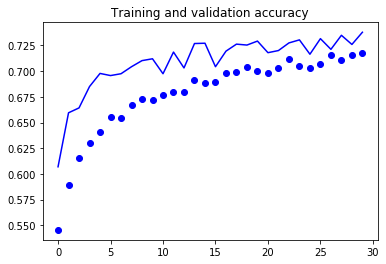

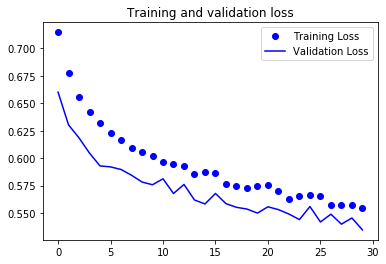

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 14. Save the trained Model

In [26]:
final_model.save('D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\deepfake-resnetV2-model_2.h5')

### 15. Load Saved Model

In [19]:
resnetV2_model = load_model('D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\deepfake-resnetV2-model_2.h5')

In [7]:
resnetV2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 55,912,674
Trainable params: 1,606,210
Non-trainable params: 54,306,464
_________________________________________________________________


### 16. Predict on test data frames and plot Confusion Matrix

In [39]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    
    tn=cm[1][1]
    fp=cm[0][1]
    fn=cm[1][0]
    tp=cm[0][0]
    
    acc = (tn+tp) / (tn+tp+fp+fn)
    prec = (tp) / (tp+fp)
    rec = (tp) / (tp+fn)
    print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )
    print('\n')
    
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

In [9]:
X_val = X_val/255.0

In [10]:
X_val.shape

(3371, 128, 128, 3)

True positive =  1050
False positive =  616
False negative =  268
True negative =  1437


Accuracy: 0.7377632749925838 Precision: 0.6302521008403361 Recall: 0.7966616084977238




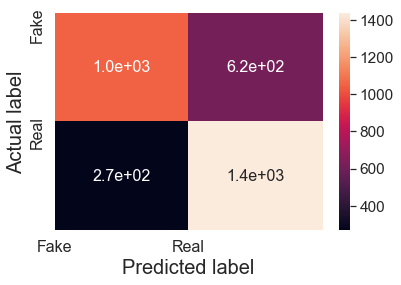

In [11]:
print_confusion_matrix(y_true,resnetV2_model.predict_classes(X_val))

### 17. Classify Test Videos as Fake or Original

In [5]:
test = test.to_frame().reset_index()
test = test.rename(columns={0:'path'})

In [6]:
test['original_label'] = np.where(test['path'].str.contains('original_sequences'), 1,0)

In [29]:
def classify_video(path,test,frames_loc):
    X=[]
    frames = [file for file in glob.glob(frames_loc + '*.jpg',recursive=True)]

    for f in frames:
        img = load_img(f,target_size=(128,128))
        img = (img_to_array(img).flatten()/255.0)
        X.append(img) 

    vid_frames = np.array(X)
    vid_frames = vid_frames.reshape(-1, 128, 128, 3)
    files = glob.glob(frames_loc+'*')
    for f in files:
        os.remove(f)
    predictions = resnetV2_model.predict_classes(vid_frames)
    # Predicated label for video is the mode of predictions for all the faces detected in the video
    pred_label = mode(predictions)
    test.loc[test['path'] == path, 'pred_label']= pred_label

In [32]:
detector = dlib.get_frontal_face_detector()
face_loc = 'D:\\MDA Stuff\\Artificial Intelligence 2\\DeepFake_Detection_Project\\Inception_data\\Frames\\vid_frames\\'
label = 'classify'
num_videos = 0
for f in test['path']:
    vid = cv2.VideoCapture(f)
    frames = 0
    while(vid.isOpened()):
            # Will generate 1 frame per second i.e 60 frames/min
        vid.set(cv2.CAP_PROP_POS_MSEC,(frames*1000))
        flag,frame = vid.read()
        if flag==True:
                #Store frames in output location
            dlib_face_extract(num_videos,frame,frames,label,face_loc,detector)
            frames = frames + 1
        else:
            break
    vid.release()
    cv2.destroyAllWindows()
    num_videos = num_videos + 1
    classify_video(f,test,face_loc)
print(str(dt.datetime.now()))
print('Video Classification Successfull')

2020-04-27 19:41:45.706383
Frame conversion Successfull


In [36]:
test['pred_label'] = test['pred_label'].astype(np.int64)

### 18. Confusion Matrix for Classification of Test Videos

True positive =  39
False positive =  21
False negative =  2
True negative =  47


Accuracy: 0.7889908256880734 Precision: 0.65 Recall: 0.9512195121951219




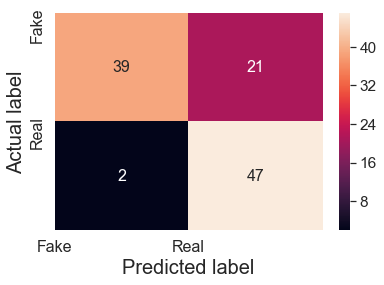

In [40]:
print_confusion_matrix(test['original_label'],test['pred_label'])